In [50]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# skearn imports
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


# info_apoio imports
from info_apoio import fetch_housing_data
from info_apoio import load_housing_data
from info_apoio import CombinedAttributesAdder
from info_apoio import data_preparation
from info_apoio import data_trasformation


# Carregando os dados, lendo e criando um repositório 

Com objetivo de carregar os dados de forma elegante, vamos fazer uma simples função, que será carregada do arquivo 'info_apoio.py', com objetivo de carregar os dados e criar um repositório. Para tal, inicialmente vamos definir a origem dos dados e o nome do repositório,

In [51]:
# loading the data
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


Com a função criada, basta carregala e escolher os parametros,


In [52]:
# creating directory
fetch_housing_data(housing_url=HOUSING_URL,
                   housing_path=HOUSING_PATH,
                   data="housing.tgz")

Agora, com os dados já carregados, precisamos lelos, para isso, novamente vamos fazer uma função, 'load_housing_data', que novamente será carregada do arquivo 'info_apoio.py'. Desata forma, podemos definir o objeto 'housing', que nada mais é do que um DataFrame da biblioteca 'pandas'.
          

In [53]:
# reading the data
housing = load_housing_data(housing_path=HOUSING_PATH,
                            data="housing.csv")

housing.head(10)   # first 10 lines

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


É facil observar que temos apenas uma coluna de dados 'não numericos', mas para analisarmos valores faltantes, fica inviaval analisar o DataFrame. Para tal tarefa vamos usar o método 'info()',

In [54]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Assim fica claro que:
- 1 coluna tem dados faltantes - 'total_bedrooms'
- 1 coluna de dados categoricos - 'ocean_proximity'

In [55]:
housing['ocean_proximity'].value_counts() # grouping equal values

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

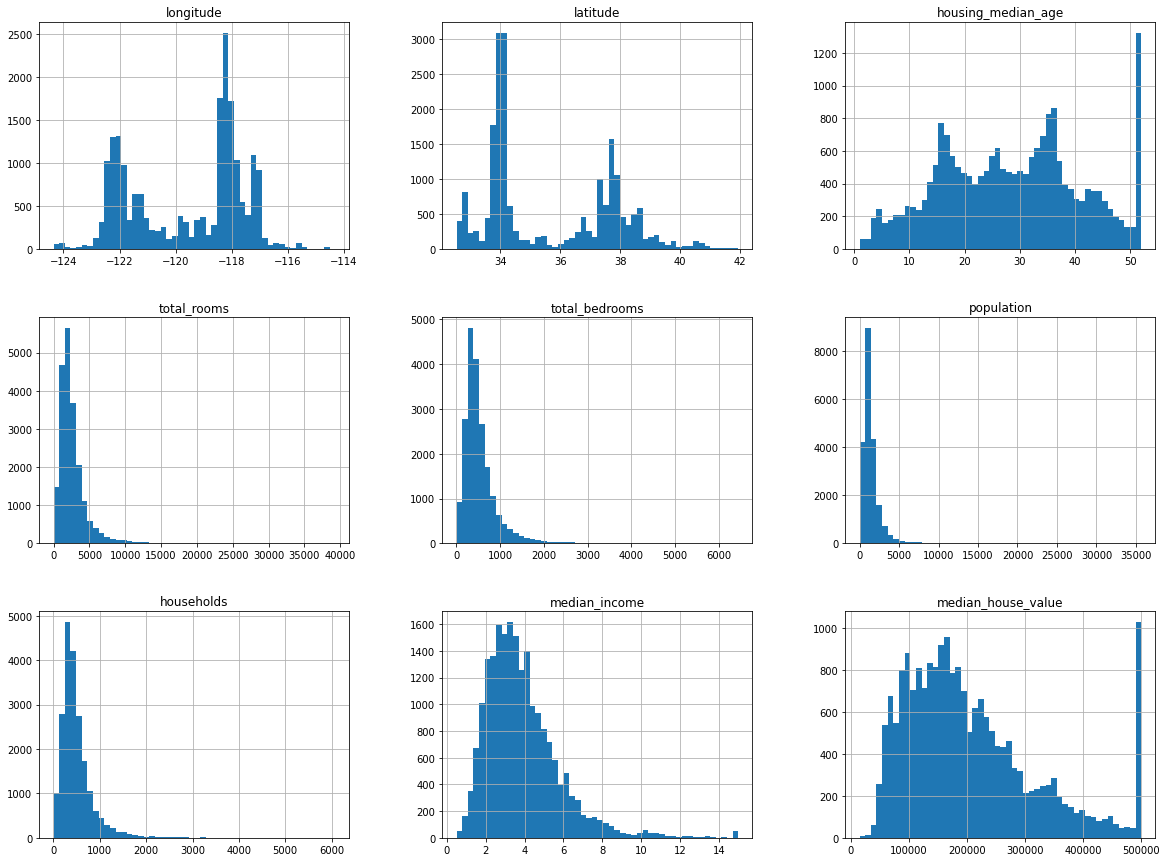

In [56]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [57]:
def split_train_test(data, test_ratio):
    
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[:test_set_size]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [58]:
train_set, test_set = split_train_test(housing, 0.2)

print('train_set: {} \n test_set: {}'.format(len(train_set), len(test_set)))

train_set: 4128 
 test_set: 4128


<AxesSubplot:>

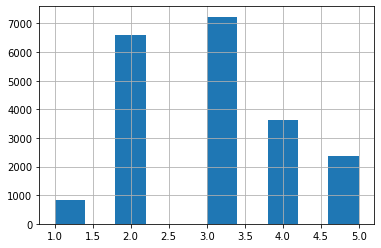

In [59]:
housing['income_cat'] = pd.cut(housing['median_income'],
                        bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                        labels=[1, 2, 3, 4, 5])

housing['income_cat'].hist()

In [60]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [61]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [62]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

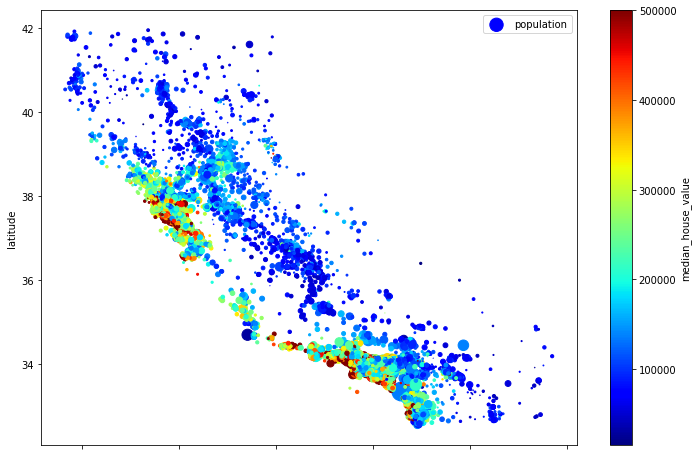

In [63]:
housing = strat_train_set.copy()

housing.plot(kind='scatter', x='longitude', y='latitude',
             s=housing['population']/100,
             label='population',
             figsize=(12, 8),
             c='median_house_value',
             cmap=plt.get_cmap('jet'),
             colorbar=True
             )

plt.show()


# Buscando correlaçãoes

In [64]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [65]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

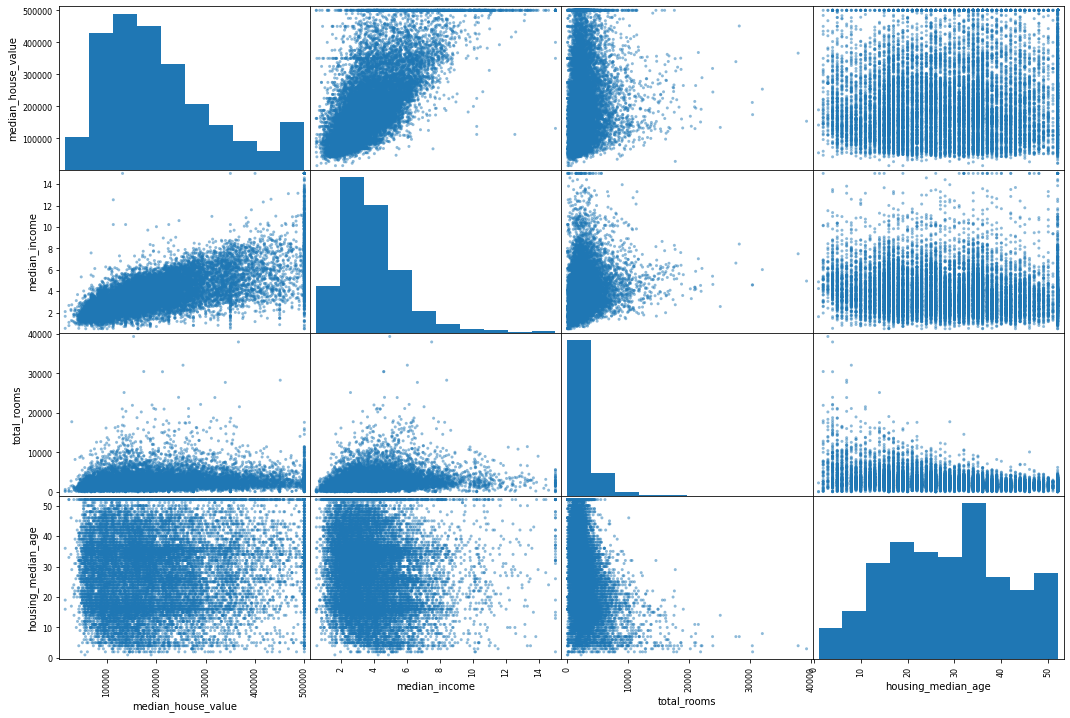

In [66]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(18, 12))

plt.show()


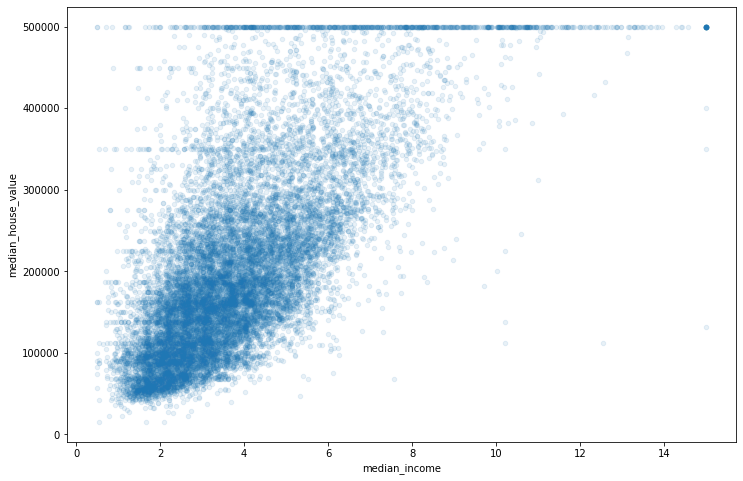

In [67]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(12, 8))

plt.show()

# Testando combinações de correlações

In [71]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [76]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# Preparando os dados

In [78]:
# setting data
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

# Limpando os dados

# Preparando os dados que vão alimentar o modelo

In [ ]:
# loading the model
data_trasformation = data_trasformation(strat_train.drop('median_house_value', axis=1), 'ocean_proximity')

# train data
X_train = data_trasformation.fit_transform(strat_train.drop(columns=['median_house_value']))
y_train = strat_train['median_house_value']

# test data
X_test = data_trasformation.fit_transform(strat_test.drop(columns=['median_house_value']))
y_test = strat_test['median_house_value']

# Melhorando os parametros 

In [ ]:
# optimizing parameters
parameter_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 4, 6, 8]}
    ]

forest_model = RandomForestRegressor()

grid_search = GridSearchCV(forest_model,
                           param_grid=parameter_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
modelo = RandomForestRegressor(grid_search.best_params_)